In [1]:
import numpy as np
import scipy
from scipy.sparse import csr_matrix, lil_matrix
from scipy.special import gamma
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from findiff import FinDiff, Identity, PDE, BoundaryConditions
import torch
from torch.utils.data import DataLoader, TensorDataset
import os
os.chdir("/home/so/Documents/Projects/NeuralInterpolation")
from models.siren import Siren

Generate a synthetic Gaussian random field by solving the SPDE
\begin{align}
(\kappa^2 - \Delta) f = \mathcal{W}.
\end{align}

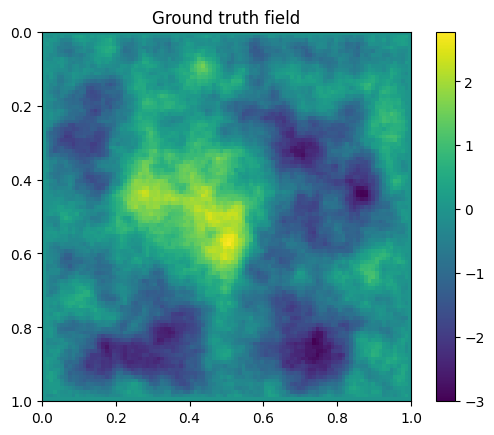

In [2]:
d = 2
ls = 0.15
nu = 1
amp = 1.1
kappa = np.sqrt(2*nu) / ls
q = ((4*np.pi)**(d/2)*kappa**(2*nu)*gamma(nu+d/2))/gamma(nu)
grid_size = 100

x = y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y, indexing='ij')
X_test = np.stack([X.flatten(), Y.flatten()], axis=1)

shape = (grid_size, grid_size)
dx = x[1]-x[0]
dy = y[1]-y[0]

# Set LHS
diff_op = kappa**2 * Identity() - FinDiff(0, dx, 2) - FinDiff(1, dy, 2)

# Set RHS
np.random.seed(0)
W = (1/np.sqrt(dx*dy)) * np.sqrt(q) * amp * np.random.randn(*shape)

# Set boundary conditions (zero-Dirichlet)
bc = BoundaryConditions(shape)
bc[0, :] = 0
bc[-1,:] = 0
bc[:, 0] = 0
bc[:, -1] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u = pde.solve()

# Plot solution
plt.imshow(u, extent=[0,1,1,0])
plt.colorbar()
plt.title('Ground truth field')
plt.show()

Sample random points for observation

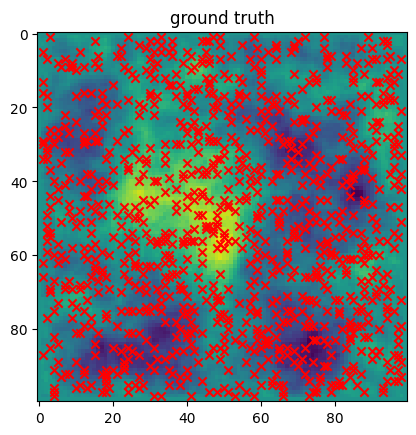

In [3]:
num_obs = 1000
obs_noise = 0

# Get observations at random locations
rng = np.random.default_rng(0)
x_idxs = y_idxs = np.arange(grid_size)
X_idxs, Y_idxs = np.meshgrid(x_idxs[1:-1], y_idxs[1:-1], indexing='ij')
all_idxs = np.stack([X_idxs.flatten(), Y_idxs.flatten()], axis=1)
idxs = rng.choice(all_idxs, num_obs, replace=False)
obs_dict = {tuple(idx): u[tuple(idx)]+obs_noise*np.random.randn() for idx in idxs}

# Plot results
plt.imshow(u)
plt.title('ground truth')
plt.scatter(idxs[:,1], idxs[:,0], c='r', marker='x')

In [4]:
# Create pytorch dataloader
X = list(obs_dict.keys())
Y = list(obs_dict.values())
X = np.array(X)
Y = np.array(Y)
tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(Y)

my_dataset = TensorDataset(tensor_x/100, tensor_y[:,None]) # create your datset
my_dataloader = DataLoader(my_dataset, batch_size=256, shuffle=True) # create your dataloader

In [9]:
def train_model(model, dataloader, optim, num_epochs=200):
    for epoch in range(num_epochs):
        epoch_loss = 0
        N = 0
        for i, data in enumerate(dataloader):
            model_input, ground_truth = data
            model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
            model_output = model(model_input)    
            loss = ((model_output - ground_truth)**2).mean()
            bs = model_input.shape[0]
            N += bs
            epoch_loss += loss * bs
            optim.zero_grad()
            loss.backward()
            optim.step()
            epoch_loss /= N
            print(f"Epoch {epoch}: loss {epoch_loss}")


def plot_predictions(model, model_name: str):
    X_test = torch.Tensor(all_idxs).cuda()
    model_output = model(X_test/100)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    divider1 = make_axes_locatable(ax1)
    im1 = ax1.imshow(u, extent=[0,1,1,0])
    ax1.set_title('Ground truth')
    cax1 = divider1.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    divider2 = make_axes_locatable(ax2)
    im2 = ax2.imshow(model_output.reshape(98,98).cpu().detach().numpy(), extent=[0,1,1,0])
    ax2.set_title(model_name + ' output')
    cax2 = divider2.append_axes('right', size='5%', pad=0.1)
    fig.colorbar(im2, cax=cax2, orientation='vertical')


# SIREN experiment

In [6]:
img_siren = Siren(in_features=2, out_features=1, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)

img_siren.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [7]:
num_epochs = 200
optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

train_model(img_siren, my_dataloader, optim, num_epochs)

Epoch 0: loss 1.232819676399231
Epoch 0: loss 0.41466253995895386
Epoch 0: loss 0.2872459292411804
Epoch 0: loss 0.16472354531288147
Epoch 1: loss 0.6172029972076416
Epoch 1: loss 0.3479696214199066
Epoch 1: loss 0.1825534701347351
Epoch 1: loss 0.1083044558763504
Epoch 2: loss 0.4919414520263672
Epoch 2: loss 0.20933189988136292
Epoch 2: loss 0.14061427116394043
Epoch 2: loss 0.08936385810375214
Epoch 3: loss 0.33941149711608887
Epoch 3: loss 0.18098412454128265
Epoch 3: loss 0.10953833907842636
Epoch 3: loss 0.08192411065101624
Epoch 4: loss 0.31088942289352417
Epoch 4: loss 0.13640491664409637
Epoch 4: loss 0.0852012187242508
Epoch 4: loss 0.06580431759357452
Epoch 5: loss 0.23361413180828094
Epoch 5: loss 0.11969027668237686
Epoch 5: loss 0.07544019818305969
Epoch 5: loss 0.04823441430926323
Epoch 6: loss 0.19213475286960602
Epoch 6: loss 0.11228815466165543
Epoch 6: loss 0.048839371651411057
Epoch 6: loss 0.03857885301113129
Epoch 7: loss 0.13384577631950378
Epoch 7: loss 0.084751

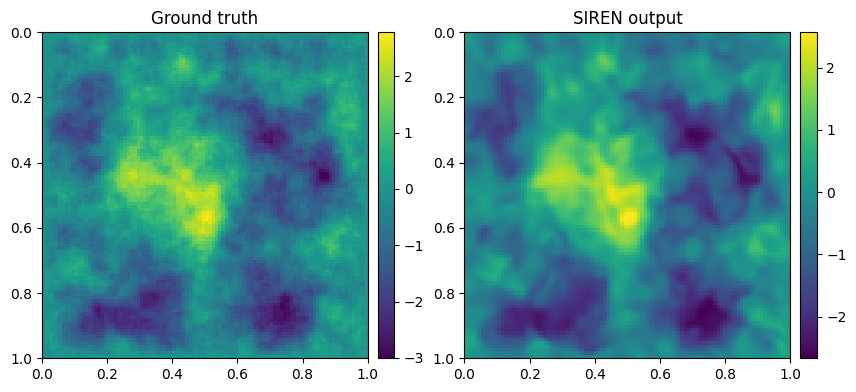

In [10]:
plot_predictions(img_siren, "SIREN")

# Vanilla MLP

In [11]:
from models.mlp import MultilayerPerceptron


mlp = MultilayerPerceptron(in_features=2, out_features=1, hidden_features=256, hidden_layers=3)
mlp.cuda()

num_epochs = 500
optim = torch.optim.Adam(lr=1e-4, params=mlp.parameters())

train_model(mlp, my_dataloader, optim, num_epochs)

Epoch 0: loss 1.0911650657653809
Epoch 0: loss 0.6074946522712708
Epoch 0: loss 0.3527184724807739
Epoch 0: loss 0.24538765847682953
Epoch 1: loss 1.0551247596740723
Epoch 1: loss 0.6208933591842651
Epoch 1: loss 0.3162686824798584
Epoch 1: loss 0.23786979913711548
Epoch 2: loss 1.2102770805358887
Epoch 2: loss 0.48435109853744507
Epoch 2: loss 0.3154869079589844
Epoch 2: loss 0.2338903397321701
Epoch 3: loss 1.1028788089752197
Epoch 3: loss 0.4671996831893921
Epoch 3: loss 0.32334208488464355
Epoch 3: loss 0.23471900820732117
Epoch 4: loss 0.9419832229614258
Epoch 4: loss 0.47041580080986023
Epoch 4: loss 0.31942856311798096
Epoch 4: loss 0.25343698263168335
Epoch 5: loss 0.9127483367919922
Epoch 5: loss 0.4274090528488159
Epoch 5: loss 0.3520570993423462
Epoch 5: loss 0.23629464209079742
Epoch 6: loss 0.9199051260948181
Epoch 6: loss 0.4542710483074188
Epoch 6: loss 0.34459492564201355
Epoch 6: loss 0.2125256061553955
Epoch 7: loss 1.052521824836731
Epoch 7: loss 0.44985440373420715


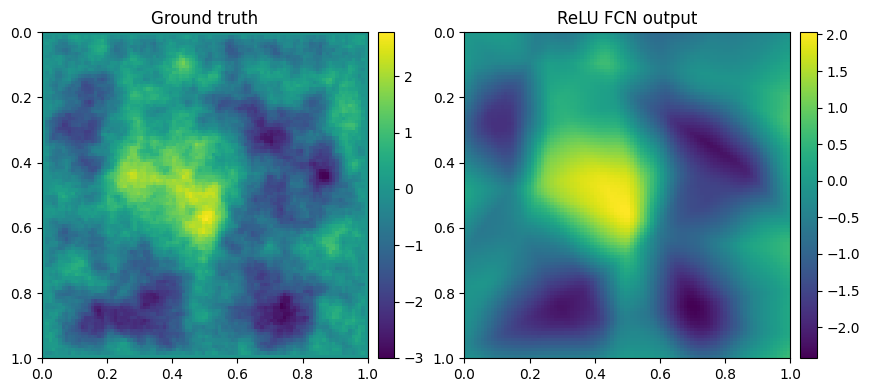

In [13]:
plot_predictions(mlp, "ReLU FCN")